In [2]:
import itertools

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import confusion_matrix


## Loading the MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize images to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# make sure images have shape (28, 28, 1). Note: -1 means expand on final axis
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)


## Visualizing the images

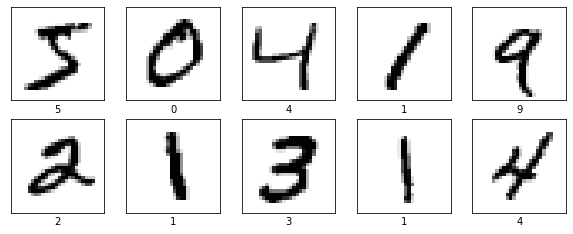

In [3]:
classes = range(10)

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

plt.show()

## Creating the model

In [4]:
model = models.Sequential()

# Add two conv and max pooling layers
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
)
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
          
# Set up the FC layer
model.add(layers.Flatten()) # need to flatten last conv layer 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10)) # have 10 classes (labels)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

### What is Dropout?

In machine learning a number of techiques exist to prevent overfitting. This is known as **regularization** with traditional methods such as L1 and L2 ([see here for more info](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)). 

However, one type of overfitting can not be corrected by L1 and L2, known as **co-adaptation**.

As a network trains, it is likely that some neurons in the network will yield more predictive power than others. As the training iterates, such neurons only become more stronger while the weaker ones are neglected. As a result only a fraction of the neurons in the network participate in the training. 

Dropout is a regularization technique that prevents co-adaption. During training at each iteration a set of neurons are temporary omitted. For more information about the math behind dropout please refer to the following article [here](https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275). Additionally, the following white paper is also worth a look [here](https://jmlr.org/papers/v15/srivastava14a.html)

![Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014](https://miro.medium.com/max/2400/1*iWQzxhVlvadk6VAJjsgXgg.png)

## Train the model

In [5]:
model.compile(
    optimizer="sgd", # stochastic gradient descent
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # See comment below for more info
    metrics=['accuracy']
)

# Logits: The vector of raw (non-normalized) predictions that a classification model generates.
# Cross Entropy: see https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

epochs = 10

fit = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

history = fit.history

model.save('my_model')
np.save('my_history.npy', history)

Epoch 1/10
1875/1875 [==============================] - 64s 34ms/step - loss: 1.2316 - accuracy: 0.5949 - val_loss: 0.1801 - val_accuracy: 0.9486
Epoch 2/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2368 - accuracy: 0.9281 - val_loss: 0.1178 - val_accuracy: 0.9662
Epoch 3/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1746 - accuracy: 0.9459 - val_loss: 0.0981 - val_accuracy: 0.9705
Epoch 4/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.1415 - accuracy: 0.9571 - val_loss: 0.0849 - val_accuracy: 0.9745
Epoch 5/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1248 - accuracy: 0.9608 - val_loss: 0.0741 - val_accuracy: 0.9775
Epoch 6/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.1212 - accuracy: 0.9630 - val_loss: 0.0687 - val_accuracy: 0.9774
Epoch 7/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.1081 - accuracy: 0.9671 - val_loss: 0.0676 -

## Evaluate

In [3]:
# Run this cell if you want to load a prev trained model
model = models.load_model("my_model")
history = np.load('my_history.npy', allow_pickle=True).item()

### Loss

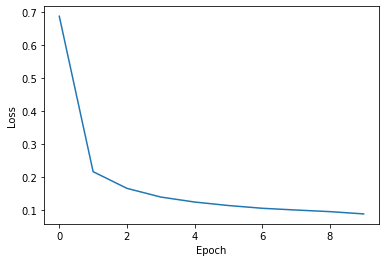

In [5]:
plt.plot(history['loss'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Accuracy

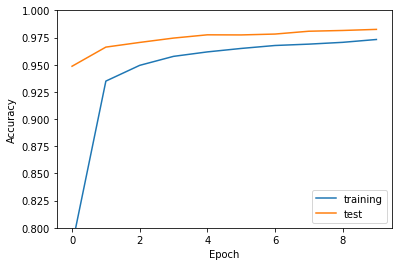

In [13]:
plt.plot(history['accuracy'], label='training')
plt.plot(history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

### Confusion matrix

In [8]:

def plot_confusion_matrix(y_test,
                          y_predict,
                          classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_predict)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

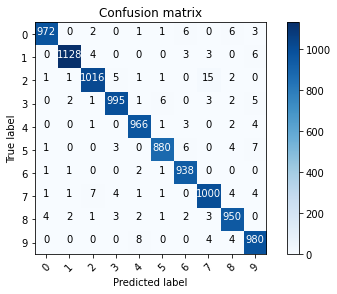

In [9]:
classes = range(10)

predictions = model.predict(x_test)

predictions = [np.argmax(p) for p in predictions]
plot_confusion_matrix(predictions, y_test, classes, normalize=False)

In [12]:
score = model.evaluate(x_train, y_train, verbose=0)
print('---------- Training ----------')
print("loss:", round(score[0], 4))
print("accuracy:", round(score[1], 4))

score = model.evaluate(x_test, y_test, verbose=0)
print('----------   Test   ----------')
print("loss:", round(score[0], 2))
print("accuracy:", round(score[1], 4))

---------- Training ----------
loss: 0.0576
accuracy: 0.9829
----------   Test   ----------
loss: 0.05
accuracy: 0.9825
